In [6]:
# Core libs and modeling tools
import pandas as pd
import numpy as np
import itertools
from scipy.special import gammaln
from scipy.optimize import minimize
from numpy.linalg import inv
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# Paths & basic settings
CSV_PATH = r"C:\Users\Vex\Desktop\main\dataset\matchday\clean_matchday_stat.csv"
MAX_GOALS = 10     # upper bound for score grids
N_SIM = 2000       # param draws for CI bands

pd.set_option("display.width", 160)
pd.set_option("display.max_columns", 200)
print("Using:", CSV_PATH)


Using: C:\Users\Vex\Desktop\main\dataset\matchday\clean_matchday_stat.csv


In [7]:
df = pd.read_csv(CSV_PATH)

# Resolve common variants of key headers
aliases = {
    "home_team": ["home_team","HomeTeam","home","Home","home side","home_side"],
    "away_team": ["away_team","AwayTeam","away","Away","away side","away_side"],
    "home_score": ["home_score","FTHG","home_goals","HomeGoals","home_fulltime_goals","home_final_goal"],
    "away_score": ["away_score","FTAG","away_goals","AwayGoals","away_fulltime_goals","away_final_goal"],
}

resolved = {}
for k, opts in aliases.items():
    for c in opts:
        if c in df.columns:
            resolved[k] = c
            break

missing = [k for k in aliases if k not in resolved]
if missing:
    raise ValueError(f"Missing required columns: {missing}")

HOME, AWAY, FTHG, FTAG = [resolved[k] for k in ["home_team","away_team","home_score","away_score"]]

# Keep scores numeric
df[FTHG] = pd.to_numeric(df[FTHG], errors="coerce").fillna(0).astype(int)
df[FTAG] = pd.to_numeric(df[FTAG], errors="coerce").fillna(0).astype(int)

teams = sorted(pd.Index(df[HOME]).append(pd.Index(df[AWAY])).unique())
n_teams = len(teams)
team_to_idx = {t:i for i,t in enumerate(teams)}
print("Teams:", n_teams)


Teams: 18


In [8]:
# θ = [home_adv, rho, attacks[0..T-2], defences[0..T-1]] with sum(attacks)=0

def pack_params_dc(theta):
    home = theta[0]
    rho  = theta[1]
    att  = theta[2:2+(n_teams-1)]
    deff = theta[2+(n_teams-1):]
    att_full = np.concatenate([att, [-att.sum()]])
    return home, rho, att_full, deff

def unpack_params_dc(home, rho, att_full, deff):
    att = att_full[:-1]
    return np.concatenate([[home, rho], att, deff])

def pois_logpmf(k, lam):
    return k*np.log(lam) - lam - gammaln(k+1)

# Low-score adjustment from Dixon–Coles
def tau_dc(x, y, lam, mu, rho):
    if (x, y) == (0, 0): return 1 - (lam*mu*rho)
    if (x, y) == (0, 1): return 1 + (lam*rho)
    if (x, y) == (1, 0): return 1 + (mu*rho)
    if (x, y) == (1, 1): return 1 - rho
    return 1.0

def match_means_dc(theta, home_idx, away_idx):
    home, rho, attack, defence = pack_params_dc(theta)
    lam = np.exp(home + attack[home_idx] - defence[away_idx])
    mu  = np.exp(attack[away_idx] - defence[home_idx])
    return lam, mu, rho

def neg_log_likelihood_dc(theta, alpha=0.01):
    home, rho, attack, defence = pack_params_dc(theta)
    pen = 0.5*(alpha*(attack**2).sum() + alpha*(defence**2).sum() + alpha*home**2 + alpha*rho**2)
    ll = 0.0
    for _, r in df.iterrows():
        hi = team_to_idx[r[HOME]]; ai = team_to_idx[r[AWAY]]
        x, y = int(r[FTHG]), int(r[FTAG])
        lam = np.exp(home + attack[hi] - defence[ai])
        mu  = np.exp(attack[ai] - defence[hi])
        t   = tau_dc(x, y, lam, mu, rho)
        ll += pois_logpmf(x, lam) + pois_logpmf(y, mu) + np.log(max(t, 1e-12))
    return -(ll - pen)

# Start small home edge; rho near 0
theta0 = np.zeros(2 + (n_teams-1) + n_teams)
theta0[0] = 0.2
theta0[1] = 0.0

res_dc = minimize(neg_log_likelihood_dc, theta0, method="L-BFGS-B")
if not res_dc.success:
    print("WARNING [DC]: optimizer did not converge:", res_dc.message)
theta_hat = res_dc.x
print("[DC] Optimized NLL:", res_dc.fun)


[DC] Optimized NLL: 891.941174300037


In [9]:
def dc_joint_matrix(lam, mu, rho, max_goals=MAX_GOALS):
    xs = np.arange(0, max_goals+1)
    ys = np.arange(0, max_goals+1)
    px = np.exp(pois_logpmf(xs[:,None], lam))
    py = np.exp(pois_logpmf(ys[None,:], mu))
    base = px @ py
    P = base.copy()
    P[0,0] *= max(tau_dc(0,0,lam,mu,rho), 1e-12)
    P[0,1] *= max(tau_dc(0,1,lam,mu,rho), 1e-12)
    P[1,0] *= max(tau_dc(1,0,lam,mu,rho), 1e-12)
    P[1,1] *= max(tau_dc(1,1,lam,mu,rho), 1e-12)
    s = P.sum()
    if s <= 0 or not np.isfinite(s):
        P = base; s = P.sum()
    return P / s

def probs_from_theta(theta):
    phw, pdraw, paw = [], [], []
    for _, r in df.iterrows():
        lam, mu, rho = match_means_dc(theta, team_to_idx[r[HOME]], team_to_idx[r[AWAY]])
        P = dc_joint_matrix(lam, mu, rho, MAX_GOALS)
        phw.append(np.tril(P, k=-1).sum())
        pdraw.append(np.trace(P))
        paw.append(np.triu(P, k=1).sum())
    return np.array(phw), np.array(pdraw), np.array(paw)

pH, pD, pA = probs_from_theta(theta_hat)
print("[DC] Mean prob sum:", float((pH+pD+pA).mean()))

df["_xPts_home_dc"] = 3*pH + pD
df["_xPts_away_dc"] = 3*pA + pD

# Observed points (for reference)
home_pts = np.select([df[FTHG] > df[FTAG], df[FTHG] == df[FTAG], df[FTHG] < df[FTAG]], [3,1,0])
away_pts = np.select([df[FTAG] > df[FTHG], df[FTAG] == df[FTHG], df[FTAG] < df[FTHG]], [3,1,0])
df["_pts_home"] = home_pts
df["_pts_away"] = away_pts

print(df[[HOME,AWAY,FTHG,FTAG,"_xPts_home_dc","_xPts_away_dc","_pts_home","_pts_away"]].head(6).to_string(index=False))


[DC] Mean prob sum: 1.0
          home_team          away_team  home_score  away_score  _xPts_home_dc  _xPts_away_dc  _pts_home  _pts_away
   Bayer Leverkusen           Augsburg           2           1       2.677051       0.212369          3          0
           Dortmund          Darmstadt           4           0       2.727138       0.180239          3          0
Eintracht Frankfurt         RB Leipzig           2           2       1.019826       1.710730          1          1
         Heidenheim            FC Koln           4           1       2.085174       0.652674          3          0
         Hoffenheim      Bayern Munich           4           2       0.862582       1.953332          3          0
          Stuttgart B. Monchengladbach           4           0       2.454251       0.402266          3          0


In [10]:
home_long = df[[HOME, AWAY, "_xPts_home_dc", "_pts_home"]].copy()
home_long.columns = ["team","opponent","xPts","pts"]
away_long = df[[AWAY, HOME, "_xPts_away_dc", "_pts_away"]].copy()
away_long.columns = ["team","opponent","xPts","pts"]
long = pd.concat([home_long, away_long], ignore_index=True)

season_dc = (long.groupby("team", as_index=False)
             .agg(matches=("pts","size"), pts=("pts","sum"), xPts_dc=("xPts","sum")))
season_dc["Pts_minus_xPts_dc"] = season_dc["pts"] - season_dc["xPts_dc"]
season_dc = season_dc.sort_values("pts", ascending=False).reset_index(drop=True)

print(season_dc.head(10).to_string(index=False))


               team  matches  pts   xPts_dc  Pts_minus_xPts_dc
   Bayer Leverkusen       34   90 82.264955           7.735045
          Stuttgart       34   73 68.723549           4.276451
      Bayern Munich       34   72 71.573372           0.426628
         RB Leipzig       34   65 68.086074          -3.086074
           Dortmund       34   63 61.612474           1.387526
Eintracht Frankfurt       34   47 48.348216          -1.348216
         Hoffenheim       34   46 47.887339          -1.887339
         Heidenheim       34   42 44.673417          -2.673417
      Werder Bremen       34   42 44.171252          -2.171252
           Freiburg       34   42 40.387367           1.612633


In [11]:
def numerical_hessian(func, x, eps=1e-4):
    p = len(x); H = np.zeros((p,p))
    fx = func(x)
    for i in range(p):
        ei = np.zeros(p); ei[i]=eps
        f_ip = func(x+ei); f_im = func(x-ei)
        for j in range(i, p):
            ej = np.zeros(p); ej[j]=eps
            if i == j:
                H[i,i] = (f_ip - 2*fx + f_im)/(eps**2)
            else:
                f_pp = func(x+ei+ej); f_pm = func(x+ei-ej)
                f_mp = func(x-ei+ej); f_mm = func(x-ei-ej)
                H[i,j] = H[j,i] = (f_pp - f_pm - f_mp + f_mm)/(4*eps**2)
    return H

H_dc = numerical_hessian(neg_log_likelihood_dc, theta_hat, eps=1e-4)
eigvals = np.linalg.eigvalsh(H_dc)
if np.min(eigvals) <= 1e-8:
    H_dc = H_dc + (1e-3 - np.min(eigvals) + 1e-8) * np.eye(H_dc.shape[0])
Sigma_dc = inv(H_dc)
rng_dc = np.random.default_rng(123)

def season_xpts_from_theta(theta):
    pH_, pD_, pA_ = probs_from_theta(theta)
    xh = 3*pH_ + pD_; xa = 3*pA_ + pD_
    home_tmp = pd.DataFrame({"team": df[HOME].values, "xPts": xh})
    away_tmp = pd.DataFrame({"team": df[AWAY].values, "xPts": xa})
    return (pd.concat([home_tmp, away_tmp]).groupby("team", as_index=False)["xPts"].sum())

theta_draws = rng_dc.multivariate_normal(theta_hat, Sigma_dc, size=N_SIM)
xpts_draws_dc = {t: [] for t in teams}
for draw in theta_draws:
    home, rho, att_full, deff = pack_params_dc(draw)
    draw_fixed = unpack_params_dc(home, rho, att_full, deff)
    table = season_xpts_from_theta(draw_fixed)
    for _, row in table.iterrows():
        xpts_draws_dc[row["team"]].append(row["xPts"])

ci_rows_dc = []
for t in teams:
    arr = np.array(xpts_draws_dc[t], dtype=float)
    lo, mid, hi = np.percentile(arr, [2.5, 50, 97.5])
    ci_rows_dc.append({"team": t, "xPts_lo": lo, "xPts_med": mid, "xPts_hi": hi})
ci_dc = pd.DataFrame(ci_rows_dc)

season_ci = season_dc.merge(ci_dc, on="team", how="left").sort_values("pts", ascending=False).reset_index(drop=True)
print(season_ci.head(12).to_string(index=False))


               team  matches  pts   xPts_dc  Pts_minus_xPts_dc   xPts_lo  xPts_med   xPts_hi
   Bayer Leverkusen       34   90 82.264955           7.735045 72.581971 81.998844 88.898267
          Stuttgart       34   73 68.723549           4.276451 57.340227 68.388869 77.908891
      Bayern Munich       34   72 71.573372           0.426628 60.509558 71.362144 80.374796
         RB Leipzig       34   65 68.086074          -3.086074 56.503820 67.792055 77.754659
           Dortmund       34   63 61.612474           1.387526 49.982310 61.450575 71.556455
Eintracht Frankfurt       34   47 48.348216          -1.348216 37.307549 48.486437 59.713739
         Hoffenheim       34   46 47.887339          -1.887339 36.415144 47.998883 59.300410
         Heidenheim       34   42 44.673417          -2.673417 33.945975 45.081649 56.460451
      Werder Bremen       34   42 44.171252          -2.171252 33.490142 43.895671 55.475519
           Freiburg       34   42 40.387367           1.612633 29.9794

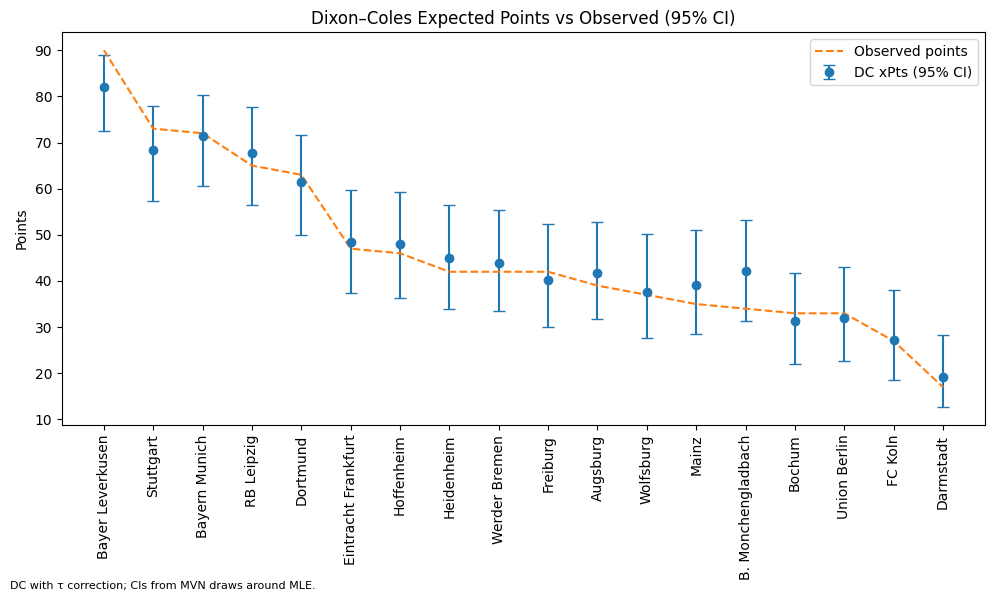

[DC] Observed total points: 837
[DC] Expected total points: 847.0
[DC] Draws: observed=81, expected=71.0


In [12]:
fig, ax = plt.subplots(figsize=(10,6))
x = np.arange(len(season_ci))

ax.errorbar(
    x, season_ci["xPts_med"],
    yerr=[season_ci["xPts_med"] - season_ci["xPts_lo"],
          season_ci["xPts_hi"] - season_ci["xPts_med"]],
    fmt="o", capsize=4, label="DC xPts (95% CI)"
)
ax.plot(x, season_ci["pts"], linestyle="--", label="Observed points")
ax.set_xticks(x); ax.set_xticklabels(season_ci["team"], rotation=90)
ax.set_ylabel("Points")
ax.set_title("Dixon–Coles Expected Points vs Observed (95% CI)")
ax.legend()
fig.text(0.01, 0.01, "DC with τ correction; CIs from MVN draws around MLE.", fontsize=8)
plt.tight_layout(); plt.show()

# Sanity checks for totals
n_draws = (df[FTHG].to_numpy() == df[FTAG].to_numpy()).sum()
obs_total = 3*len(df) - n_draws
exp_total_dc = float(np.sum(3 - pD))
print(f"[DC] Observed total points: {obs_total}")
print(f"[DC] Expected total points: {exp_total_dc:.1f}")
print(f"[DC] Draws: observed={n_draws}, expected={np.sum(pD):.1f}")


In [13]:
# φ = [home_adv, attacks[0..T-2], defences[0..T-1]] with sum(attacks)=0

def pack_params_ip(phi):
    home = phi[0]
    att  = phi[1:1+(n_teams-1)]
    deff = phi[1+(n_teams-1):]
    att_full = np.concatenate([att, [-att.sum()]])
    return home, att_full, deff

def unpack_params_ip(home, att_full, deff):
    att = att_full[:-1]
    return np.concatenate([[home], att, deff])

def match_means_ip(phi, home_idx, away_idx):
    home, attack, defence = pack_params_ip(phi)
    lam = np.exp(home + attack[home_idx] - defence[away_idx])
    mu  = np.exp(attack[away_idx] - defence[home_idx])
    return lam, mu

def neg_log_likelihood_ip(phi, alpha=0.01):
    home, attack, defence = pack_params_ip(phi)
    pen = 0.5*(alpha*(attack**2).sum() + alpha*(defence**2).sum() + alpha*home**2)
    ll = 0.0
    for _, r in df.iterrows():
        hi = team_to_idx[r[HOME]]; ai = team_to_idx[r[AWAY]]
        x, y = int(r[FTHG]), int(r[FTAG])
        lam = np.exp(home + attack[hi] - defence[ai])
        mu  = np.exp(attack[ai] - defence[hi])
        ll += pois_logpmf(x, lam) + pois_logpmf(y, mu)
    return -(ll - pen)

phi0 = np.zeros(1 + (n_teams-1) + n_teams)
phi0[0] = 0.2
res_ip = minimize(neg_log_likelihood_ip, phi0, method="L-BFGS-B")
if not res_ip.success:
    print("WARNING [IP]: optimizer did not converge:", res_ip.message)
phi_hat = res_ip.x
print("[IP] Optimized NLL:", res_ip.fun)


[IP] Optimized NLL: 894.2097379924885


In [14]:
def ip_joint_matrix(lam, mu, max_goals=MAX_GOALS):
    xs = np.arange(0, max_goals+1)
    ys = np.arange(0, max_goals+1)
    px = np.exp(pois_logpmf(xs[:,None], lam))
    py = np.exp(pois_logpmf(ys[None,:], mu))
    P  = px @ py
    P /= P.sum()
    return P

def probs_from_phi(phi):
    pH, pD, pA = [], [], []
    for _, r in df.iterrows():
        lam, mu = match_means_ip(phi, team_to_idx[r[HOME]], team_to_idx[r[AWAY]])
        P = ip_joint_matrix(lam, mu, MAX_GOALS)
        pH.append(np.tril(P, k=-1).sum())
        pD.append(np.trace(P))
        pA.append(np.triu(P, k=1).sum())
    return np.array(pH), np.array(pD), np.array(pA)

pH_ip, pD_ip, pA_ip = probs_from_phi(phi_hat)
print("[IP] Mean prob sum:", float((pH_ip+pD_ip+pA_ip).mean()))

df["_xPts_home_ip"] = 3*pH_ip + pD_ip
df["_xPts_away_ip"] = 3*pA_ip + pD_ip


[IP] Mean prob sum: 1.0


In [15]:
home_long_ip = df[[HOME, AWAY, "_xPts_home_ip", "_pts_home"]].copy()
home_long_ip.columns = ["team","opponent","xPts","pts"]
away_long_ip = df[[AWAY, HOME, "_xPts_away_ip", "_pts_away"]].copy()
away_long_ip.columns = ["team","opponent","xPts","pts"]
long_ip = pd.concat([home_long_ip, away_long_ip], ignore_index=True)

season_ip = (long_ip.groupby("team", as_index=False)
             .agg(matches=("pts","size"), pts=("pts","sum"), xPts_ip=("xPts","sum")))
season_ip["Pts_minus_xPts_ip"] = season_ip["pts"] - season_ip["xPts_ip"]
season_ip = season_ip.sort_values("pts", ascending=False).reset_index(drop=True)

print(season_ip.head(10).to_string(index=False))


               team  matches  pts   xPts_ip  Pts_minus_xPts_ip
   Bayer Leverkusen       34   90 82.606880           7.393120
          Stuttgart       34   73 69.184350           3.815650
      Bayern Munich       34   72 72.139915          -0.139915
         RB Leipzig       34   65 68.746261          -3.746261
           Dortmund       34   63 62.076045           0.923955
Eintracht Frankfurt       34   47 48.409176          -1.409176
         Hoffenheim       34   46 48.659141          -2.659141
         Heidenheim       34   42 45.064557          -3.064557
      Werder Bremen       34   42 44.337830          -2.337830
           Freiburg       34   42 40.353999           1.646001


In [16]:
H_ip = numerical_hessian(neg_log_likelihood_ip, phi_hat, eps=1e-4)
eig_ip = np.linalg.eigvalsh(H_ip)
if np.min(eig_ip) <= 1e-8:
    H_ip = H_ip + (1e-3 - np.min(eig_ip) + 1e-8) * np.eye(H_ip.shape[0])
Sigma_ip = inv(H_ip)
rng_ip = np.random.default_rng(321)

def season_xpts_from_phi(phi):
    pH_, pD_, pA_ = probs_from_phi(phi)
    xh = 3*pH_ + pD_; xa = 3*pA_ + pD_
    home_tmp = pd.DataFrame({"team": df[HOME].values, "xPts": xh})
    away_tmp = pd.DataFrame({"team": df[AWAY].values, "xPts": xa})
    return (pd.concat([home_tmp, away_tmp]).groupby("team", as_index=False)["xPts"].sum())

phi_draws = rng_ip.multivariate_normal(phi_hat, Sigma_ip, size=N_SIM)
xpts_draws_ip = {t: [] for t in teams}
for draw in phi_draws:
    home, att_full, deff = pack_params_ip(draw)
    draw_fixed = unpack_params_ip(home, att_full, deff)
    tbl = season_xpts_from_phi(draw_fixed)
    for _, row in tbl.iterrows():
        xpts_draws_ip[row["team"]].append(row["xPts"])

ci_rows_ip = []
for t in teams:
    arr = np.array(xpts_draws_ip[t], dtype=float)
    lo, mid, hi = np.percentile(arr, [2.5, 50, 97.5])
    ci_rows_ip.append({"team": t, "xPts_ip_lo": lo, "xPts_ip_med": mid, "xPts_ip_hi": hi})
ci_ip = pd.DataFrame(ci_rows_ip)

season_ci_ip = (season_ip.merge(ci_ip, on="team", how="left")
                .sort_values("pts", ascending=False).reset_index(drop=True))
print(season_ci_ip.head(12).to_string(index=False))


               team  matches  pts   xPts_ip  Pts_minus_xPts_ip  xPts_ip_lo  xPts_ip_med  xPts_ip_hi
   Bayer Leverkusen       34   90 82.606880           7.393120   72.954472    82.426862   89.070572
          Stuttgart       34   73 69.184350           3.815650   58.034177    68.876263   78.438053
      Bayern Munich       34   72 72.139915          -0.139915   61.692221    71.957555   80.789734
         RB Leipzig       34   65 68.746261          -3.746261   58.016907    68.643153   77.972547
           Dortmund       34   63 62.076045           0.923955   50.416267    61.805607   72.506695
Eintracht Frankfurt       34   47 48.409176          -1.409176   36.521686    48.055905   59.382512
         Hoffenheim       34   46 48.659141          -2.659141   37.694806    48.693389   59.650511
         Heidenheim       34   42 45.064557          -3.064557   34.157077    44.986071   56.392398
      Werder Bremen       34   42 44.337830          -2.337830   33.615206    44.453931   55.865014


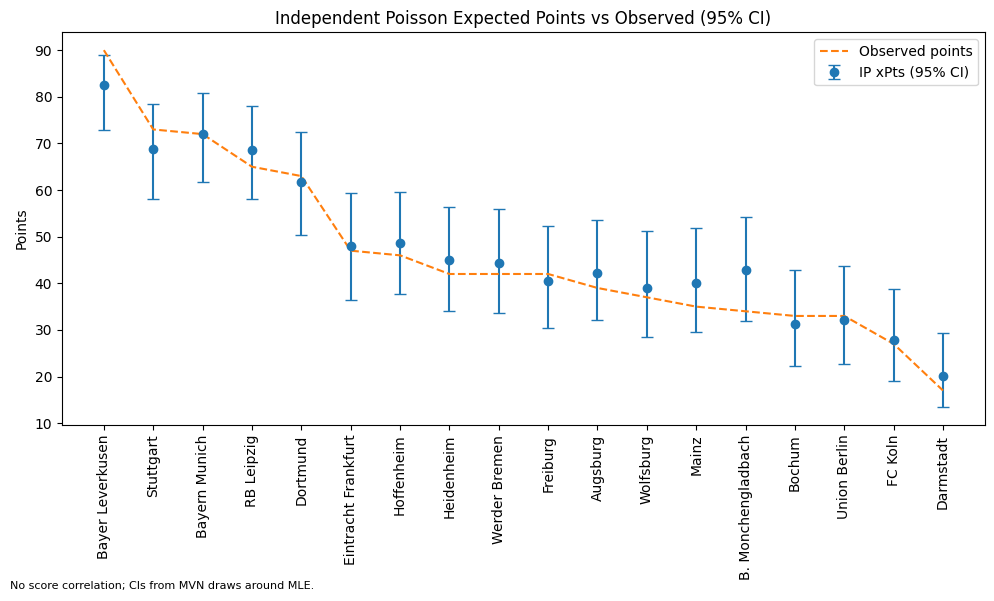

[IP] Expected total league points: 856.4  |  Expected draws: 61.6


In [17]:
fig, ax = plt.subplots(figsize=(10,6))
x = np.arange(len(season_ci_ip))

ax.errorbar(
    x, season_ci_ip["xPts_ip_med"],
    yerr=[season_ci_ip["xPts_ip_med"] - season_ci_ip["xPts_ip_lo"],
          season_ci_ip["xPts_ip_hi"] - season_ci_ip["xPts_ip_med"]],
    fmt="o", capsize=4, label="IP xPts (95% CI)"
)
ax.plot(x, season_ci_ip["pts"], linestyle="--", label="Observed points")
ax.set_xticks(x); ax.set_xticklabels(season_ci_ip["team"], rotation=90)
ax.set_ylabel("Points")
ax.set_title("Independent Poisson Expected Points vs Observed (95% CI)")
ax.legend()
fig.text(0.01, 0.01, "No score correlation; CIs from MVN draws around MLE.", fontsize=8)
plt.tight_layout(); plt.show()

exp_total_ip = float(np.sum(3 - pD_ip))
print(f"[IP] Expected total league points: {exp_total_ip:.1f}  |  Expected draws: {np.sum(pD_ip):.1f}")


In [18]:
# ψ = [home_adv, log(λ3), attacks[0..T-2], defences[0..T-1]]

def pack_params_bp(psi):
    home  = psi[0]
    kappa = psi[1]
    att   = psi[2:2+(n_teams-1)]
    deff  = psi[2+(n_teams-1):]
    att_full = np.concatenate([att, [-att.sum()]])
    return home, kappa, att_full, deff

def unpack_params_bp(home, kappa, att_full, deff):
    att = att_full[:-1]
    return np.concatenate([[home, kappa], att, deff])

def match_means_bp(psi, home_idx, away_idx):
    home, kappa, attack, defence = pack_params_bp(psi)
    lam1 = np.exp(home + attack[home_idx] - defence[away_idx])
    lam2 = np.exp(attack[away_idx] - defence[home_idx])
    lam3 = np.exp(kappa)
    return lam1, lam2, lam3

def bvpois_logpmf(x, y, lam1, lam2, lam3):
    m = min(x, y)
    ks = np.arange(m+1)
    base = -(lam1 + lam2 + lam3)
    term = ((x-ks)*np.log(lam1) + (y-ks)*np.log(lam2) + ks*np.log(max(lam3,1e-12))
            - gammaln(x-ks+1) - gammaln(y-ks+1) - gammaln(ks+1))
    mx = np.max(term)
    return base + mx + np.log(np.sum(np.exp(term - mx)))

# Mild shrinkage; a bit stronger on kappa to control over-correlation
ALPHA_HOME  = 0.01
ALPHA_KAPPA = 0.10
ALPHA_ATT   = 0.01
ALPHA_DEF   = 0.01

def neg_log_likelihood_bp(psi):
    home, kappa, attack, defence = pack_params_bp(psi)
    pen = 0.5*(ALPHA_ATT*(attack**2).sum() +
               ALPHA_DEF*(defence**2).sum() +
               ALPHA_HOME*home**2 +
               ALPHA_KAPPA*kappa**2)
    ll = 0.0
    for _, r in df.iterrows():
        hi = team_to_idx[r[HOME]]; ai = team_to_idx[r[AWAY]]
        x, y = int(r[FTHG]), int(r[FTAG])
        lam1 = np.exp(home + attack[hi] - defence[ai])
        lam2 = np.exp(attack[ai] - defence[hi])
        lam3 = np.exp(kappa)
        ll += bvpois_logpmf(x, y, lam1, lam2, lam3)
    return -(ll - pen)

psi0 = np.zeros(2 + (n_teams-1) + n_teams)
psi0[0] = 0.2
psi0[1] = -1.5

# Conservative bounds for stability
bounds = [(-1.5, 1.5), (-3.0, 0.5)] + [(-2.5, 2.5)]*(n_teams-1+n_teams)

res_bp = minimize(neg_log_likelihood_bp, psi0, method="L-BFGS-B", bounds=bounds)
if not res_bp.success:
    print("WARNING [BP]: optimizer did not converge:", res_bp.message)
psi_hat = res_bp.x

lam3_hat = float(np.exp(psi_hat[1]))
print("[BP] Optimized NLL:", res_bp.fun, "| lambda3 (shared) =", f"{lam3_hat:.3f}")


[BP] Optimized NLL: 894.8823485682138 | lambda3 (shared) = 0.050


In [19]:
def _stable_pois_pmf_vector(max_goals, lam):
    G = int(max_goals)
    xs = np.arange(0, G+1)
    lam = float(np.clip(lam, 1e-12, 1e6))
    logp = pois_logpmf(xs, lam)
    m = np.max(logp)
    p = np.exp(logp - m)
    s = p.sum()
    if not np.isfinite(s) or s <= 0:
        p = np.zeros(G+1); p[min(int(np.floor(lam)), G)] = 1.0; s = 1.0
    return p / s

def _ip_joint_matrix_safe(lam, mu, max_goals):
    px = _stable_pois_pmf_vector(max_goals, lam)[:, None]
    py = _stable_pois_pmf_vector(max_goals, mu)[None, :]
    P = px @ py
    total = P.sum()
    if not np.isfinite(total) or total <= 0:
        P[:] = 0.0; P[0,0] = 1.0; total = 1.0
    return P / total

def _bp_joint_matrix_safe(lam1, lam2, lam3, max_goals):
    G = int(max_goals)
    P = np.zeros((G+1, G+1))
    lam1 = float(np.clip(lam1, 1e-12, 1e6))
    lam2 = float(np.clip(lam2, 1e-12, 1e6))
    lam3 = float(np.clip(lam3, 0.0,    1e6))
    for x in range(G+1):
        for y in range(G+1):
            m = min(x, y)
            ks = np.arange(m+1)
            base = -(lam1 + lam2 + lam3)
            term = ((x-ks)*np.log(lam1) + (y-ks)*np.log(lam2) + ks*np.log(max(lam3,1e-12))
                    - gammaln(x-ks+1) - gammaln(y-ks+1) - gammaln(ks+1))
            mx = np.max(term)
            P[x, y] = np.exp(base + mx) * np.sum(np.exp(term - mx))
    s = P.sum()
    if not np.isfinite(s) or s <= 0:
        return _ip_joint_matrix_safe(lam1 + lam3, lam2 + lam3, G)
    return P / s

def probs_from_psi(psi, max_goals=MAX_GOALS):
    pH, pD, pA = [], [], []
    for _, r in df.iterrows():
        hi = team_to_idx[r[HOME]]; ai = team_to_idx[r[AWAY]]
        lam1, lam2, lam3 = match_means_bp(psi, hi, ai)
        P = _bp_joint_matrix_safe(lam1, lam2, lam3, max_goals)
        pH.append(np.tril(P, k=-1).sum())
        pD.append(np.trace(P))
        pA.append(np.triu(P, k=1).sum())
    return np.array(pH), np.array(pD), np.array(pA)

pH_bp, pD_bp, pA_bp = probs_from_psi(psi_hat, MAX_GOALS)
print("[BP] Mean prob sum:", float((pH_bp + pD_bp + pA_bp).mean()))

df["_xPts_home_bp"] = 3*pH_bp + pD_bp
df["_xPts_away_bp"] = 3*pA_bp + pD_bp


[BP] Mean prob sum: 1.0


In [20]:
home_long_bp = df[[HOME, AWAY, "_xPts_home_bp", "_pts_home"]].copy()
home_long_bp.columns = ["team","opponent","xPts","pts"]
away_long_bp = df[[AWAY, HOME, "_xPts_away_bp", "_pts_away"]].copy()
away_long_bp.columns = ["team","opponent","xPts","pts"]

long_bp = pd.concat([home_long_bp, away_long_bp], ignore_index=True)

season_bp = (long_bp.groupby("team", as_index=False)
             .agg(matches=("pts","size"), pts=("pts","sum"), xPts_bp=("xPts","sum")))
season_bp["Pts_minus_xPts_bp"] = season_bp["pts"] - season_bp["xPts_bp"]
season_bp = season_bp.sort_values("pts", ascending=False).reset_index(drop=True)

print(season_bp.head(10).to_string(index=False))


               team  matches  pts   xPts_bp  Pts_minus_xPts_bp
   Bayer Leverkusen       34   90 82.944876           7.055124
          Stuttgart       34   73 69.326917           3.673083
      Bayern Munich       34   72 72.237526          -0.237526
         RB Leipzig       34   65 68.930257          -3.930257
           Dortmund       34   63 62.190861           0.809139
Eintracht Frankfurt       34   47 48.368791          -1.368791
         Hoffenheim       34   46 48.667023          -2.667023
         Heidenheim       34   42 44.949814          -2.949814
      Werder Bremen       34   42 44.276844          -2.276844
           Freiburg       34   42 40.206809           1.793191


In [21]:
EPS = 1e-4
MAX_GOALS_CI = min(MAX_GOALS, 7)

# Diagonal-only curvature for a stable Σ
p = len(psi_hat)
diagH = np.empty(p, dtype=float)
f0 = neg_log_likelihood_bp(psi_hat)
for i in range(p):
    ei = np.zeros(p); ei[i] = EPS
    f_ip = neg_log_likelihood_bp(psi_hat + ei)
    f_im = neg_log_likelihood_bp(psi_hat - ei)
    diagH[i] = (f_ip - 2*f0 + f_im) / (EPS**2)
diagH = np.maximum(diagH, 1e-6)
Sigma_bp = np.diag(1.0 / diagH)

team_list = list(teams)
team_index = {t:i for i,t in enumerate(team_list)}

def season_xpts_vec(psi, grid_goals):
    pH_, pD_, pA_ = probs_from_psi(psi, grid_goals)
    xh = 3*pH_ + pD_; xa = 3*pA_ + pD_
    home_tmp = pd.DataFrame({"team": df[HOME].values, "xPts": xh})
    away_tmp = pd.DataFrame({"team": df[AWAY].values, "xPts": xa})
    tot = (pd.concat([home_tmp, away_tmp]).groupby("team", as_index=False)["xPts"].sum())
    out = np.zeros(len(team_list), dtype=float)
    for _, r in tot.iterrows():
        out[team_index[r["team"]]] = r["xPts"]
    return out

xpts_hat_vec = season_xpts_vec(psi_hat, MAX_GOALS_CI)

# Forward-diff Jacobian of xPts wrt ψ
G = np.zeros((len(team_list), p), dtype=float)
for j in range(p):
    ej = np.zeros(p); ej[j] = EPS
    xp = season_xpts_vec(psi_hat + ej, MAX_GOALS_CI)
    G[:, j] = (xp - xpts_hat_vec) / EPS

# Delta-method SEs and 95% CIs
vars_vec = (G**2) @ np.diag(Sigma_bp)
se_vec = np.sqrt(np.clip(vars_vec, 0.0, None))
z = 1.96
ci_lo = xpts_hat_vec - z * se_vec
ci_hi = xpts_hat_vec + z * se_vec

ci_bp = pd.DataFrame({
    "team": team_list,
    "xPts_bp_lo": ci_lo,
    "xPts_bp_med": xpts_hat_vec,
    "xPts_bp_hi": ci_hi
})

season_ci_bp = (season_bp.merge(ci_bp, on="team", how="left")
                .sort_values("pts", ascending=False).reset_index(drop=True))
print(season_ci_bp.head(12).to_string(index=False))


               team  matches  pts   xPts_bp  Pts_minus_xPts_bp  xPts_bp_lo  xPts_bp_med  xPts_bp_hi
   Bayer Leverkusen       34   90 82.944876           7.055124   75.055223    82.851954   90.648686
          Stuttgart       34   73 69.326917           3.673083   59.378996    69.241943   79.104890
      Bayern Munich       34   72 72.237526          -0.237526   62.585522    72.039826   81.494130
         RB Leipzig       34   65 68.930257          -3.930257   58.919814    68.851283   78.782753
           Dortmund       34   63 62.190861           0.809139   51.703306    62.145759   72.588213
Eintracht Frankfurt       34   47 48.368791          -1.368791   37.823286    48.370522   58.917758
         Hoffenheim       34   46 48.667023          -2.667023   38.147538    48.675984   59.204431
         Heidenheim       34   42 44.949814          -2.949814   34.533525    44.960801   55.388077
      Werder Bremen       34   42 44.276844          -2.276844   33.957222    44.288429   54.619636


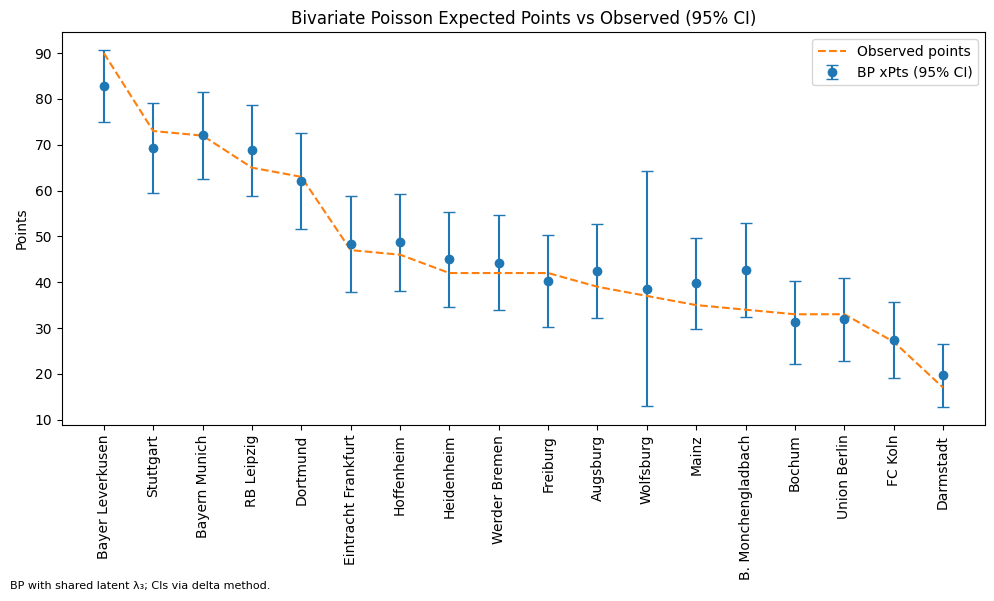

[BP] Expected total league points: 855.4  |  Expected draws: 62.6


In [22]:
fig, ax = plt.subplots(figsize=(10,6))
x = np.arange(len(season_ci_bp))

ax.errorbar(
    x, season_ci_bp["xPts_bp_med"],
    yerr=[season_ci_bp["xPts_bp_med"] - season_ci_bp["xPts_bp_lo"],
          season_ci_bp["xPts_bp_hi"] - season_ci_bp["xPts_bp_med"]],
    fmt="o", capsize=4, label="BP xPts (95% CI)"
)
ax.plot(x, season_ci_bp["pts"], linestyle="--", label="Observed points")
ax.set_xticks(x); ax.set_xticklabels(season_ci_bp["team"], rotation=90)
ax.set_ylabel("Points")
ax.set_title("Bivariate Poisson Expected Points vs Observed (95% CI)")
ax.legend()
fig.text(0.01, 0.01, "BP with shared latent λ₃; CIs via delta method.", fontsize=8)
plt.tight_layout(); plt.show()

exp_total_bp = float(np.sum(3 - pD_bp))
print(f"[BP] Expected total league points: {exp_total_bp:.1f}  |  Expected draws: {np.sum(pD_bp):.1f}")


In [23]:
TEAM_A = "Bayer Leverkusen"
TEAM_B = "Bayern Munich"
N_SIM_PLOT = 600  # for visuals

# Observed points table (reuse if already built)
if "season_dc" not in globals():
    home_tmp = pd.DataFrame({"team": df[HOME].values, "pts": df["_pts_home"].values})
    away_tmp = pd.DataFrame({"team": df[AWAY].values, "pts": df["_pts_away"].values})
    season_obs = (pd.concat([home_tmp, away_tmp]).groupby("team", as_index=False)["pts"].sum())
else:
    season_obs = season_dc[["team","pts"]].copy()

def _obs_row(team):
    row = season_obs.loc[season_obs["team"]==team]
    if row.empty:
        raise ValueError(f"Team not found: {team}.")
    return {"team": team, "pts_obs": float(row["pts"].iloc[0])}

obs_A = _obs_row(TEAM_A)
obs_B = _obs_row(TEAM_B)


C:\Users\Vex\AppData\Local\Temp\ipykernel_19052\2222096488.py:43: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([draws_A, draws_B], labels=[obs_A["team"], obs_B["team"]], showfliers=False, widths=0.6)


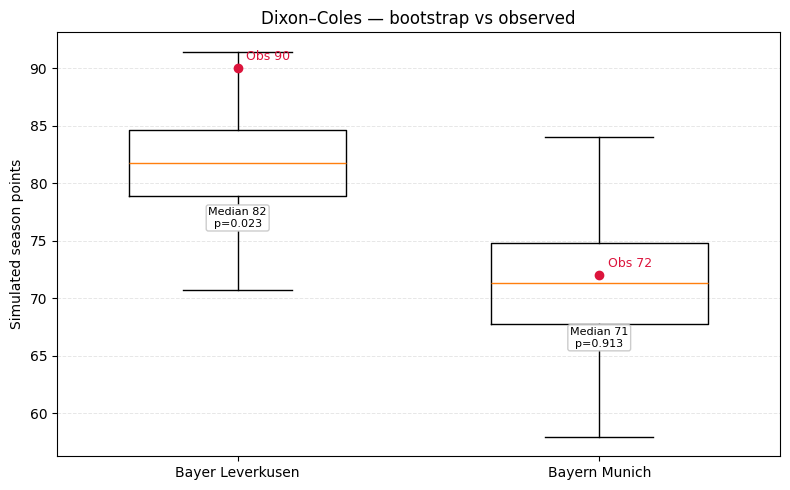

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Use existing draws if present; otherwise draw quickly
if "xpts_draws" in globals() and isinstance(xpts_draws, dict) and TEAM_A in xpts_draws and TEAM_B in xpts_draws:
    draws_A = np.array(xpts_draws[TEAM_A], dtype=float)
    draws_B = np.array(xpts_draws[TEAM_B], dtype=float)
else:
    if "Sigma_dc" not in globals():
        H_dc = numerical_hessian(neg_log_likelihood_dc, theta_hat, eps=1e-4)
        eig = np.linalg.eigvalsh(H_dc)
        if np.min(eig) <= 1e-8:
            H_dc = H_dc + (1e-3 - np.min(eig) + 1e-8) * np.eye(H_dc.shape[0])
        Sigma_dc = inv(H_dc)
    rng = np.random.default_rng(4242)
    draws = rng.multivariate_normal(theta_hat, Sigma_dc, size=N_SIM_PLOT)

    def season_xpts_from_theta(theta):
        pH_, pD_, pA_ = probs_from_theta(theta)
        xh = 3*pH_ + pD_; xa = 3*pA_ + pD_
        home_tmp = pd.DataFrame({"team": df[HOME].values, "xPts": xh})
        away_tmp = pd.DataFrame({"team": df[AWAY].values, "xPts": xa})
        return (pd.concat([home_tmp, away_tmp]).groupby("team", as_index=False)["xPts"].sum())

    draws_A, draws_B = [], []
    for dr in draws:
        home, rho, att_full, deff = pack_params_dc(dr)
        dr_fix = unpack_params_dc(home, rho, att_full, deff)
        tbl = season_xpts_from_theta(dr_fix).set_index("team")["xPts"]
        if TEAM_A in tbl: draws_A.append(tbl[TEAM_A])
        if TEAM_B in tbl: draws_B.append(tbl[TEAM_B])
    draws_A, draws_B = np.array(draws_A), np.array(draws_B)

def two_sided_p(sim, obs):
    sim = np.asarray(sim, dtype=float)
    return float(min(1.0, 2*min(np.mean(sim <= obs), np.mean(sim >= obs))))

A_med, B_med = float(np.median(draws_A)), float(np.median(draws_B))
A_p = two_sided_p(draws_A, obs_A["pts_obs"])
B_p = two_sided_p(draws_B, obs_B["pts_obs"])

fig, ax = plt.subplots(figsize=(8,5))
ax.boxplot([draws_A, draws_B], labels=[obs_A["team"], obs_B["team"]], showfliers=False, widths=0.6)
ax.set_ylabel("Simulated season points")
ax.set_title("Dixon–Coles — bootstrap vs observed")
ax.grid(True, axis="y", alpha=0.3, linestyle="--", linewidth=0.7)

for i, obs in enumerate([obs_A["pts_obs"], obs_B["pts_obs"]], start=1):
    ax.plot([i], [obs], "o", color="crimson", markersize=6, zorder=3)
    ax.annotate(f"Obs {int(obs)}", xy=(i, obs), xytext=(6, 6),
                textcoords="offset points", fontsize=9, color="crimson")

for i, (med, pval) in enumerate([(A_med, A_p), (B_med, B_p)], start=1):
    ax.annotate(f"Median {med:.0f}\np={pval:.3f}",
                xy=(i, med), xytext=(0, -32),
                textcoords="offset points", ha="center", va="top",
                fontsize=8, bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="0.8"))

plt.tight_layout(); plt.show()


C:\Users\Vex\AppData\Local\Temp\ipykernel_19052\2515240543.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([draws_A, draws_B], labels=[obs_A["team"], obs_B["team"]], showfliers=False, widths=0.6)


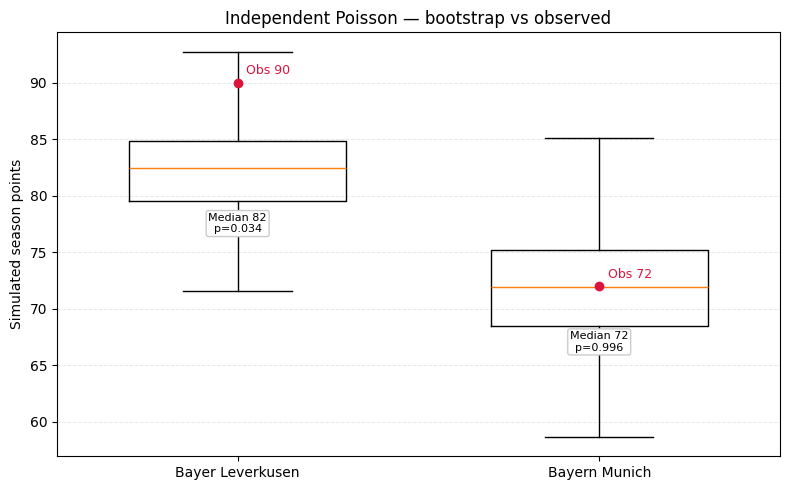

In [25]:
import numpy as np
import matplotlib.pyplot as plt

if "xpts_draws_ip" in globals() and TEAM_A in xpts_draws_ip and TEAM_B in xpts_draws_ip:
    draws_A = np.array(xpts_draws_ip[TEAM_A], dtype=float)
    draws_B = np.array(xpts_draws_ip[TEAM_B], dtype=float)
else:
    if "Sigma_ip" not in globals():
        H_ip = numerical_hessian(neg_log_likelihood_ip, phi_hat, eps=1e-4)
        eig = np.linalg.eigvalsh(H_ip)
        if np.min(eig) <= 1e-8:
            H_ip = H_ip + (1e-3 - np.min(eig) + 1e-8) * np.eye(H_ip.shape[0])
        Sigma_ip = inv(H_ip)
    rng = np.random.default_rng(5150)
    draws = rng.multivariate_normal(phi_hat, Sigma_ip, size=N_SIM_PLOT)

    def season_xpts_from_phi(phi):
        pH_, pD_, pA_ = probs_from_phi(phi)
        xh = 3*pH_ + pD_; xa = 3*pA_ + pD_
        home_tmp = pd.DataFrame({"team": df[HOME].values, "xPts": xh})
        away_tmp = pd.DataFrame({"team": df[AWAY].values, "xPts": xa})
        return (pd.concat([home_tmp, away_tmp]).groupby("team", as_index=False)["xPts"].sum())

    draws_A, draws_B = [], []
    for dr in draws:
        home, att_full, deff = pack_params_ip(dr)
        dr_fix = unpack_params_ip(home, att_full, deff)
        tbl = season_xpts_from_phi(dr_fix).set_index("team")["xPts"]
        if TEAM_A in tbl: draws_A.append(tbl[TEAM_A])
        if TEAM_B in tbl: draws_B.append(tbl[TEAM_B])
    draws_A, draws_B = np.array(draws_A), np.array(draws_B)

def two_sided_p(sim, obs):
    sim = np.asarray(sim, dtype=float)
    return float(min(1.0, 2*min(np.mean(sim <= obs), np.mean(sim >= obs))))

A_med, B_med = float(np.median(draws_A)), float(np.median(draws_B))
A_p = two_sided_p(draws_A, obs_A["pts_obs"])
B_p = two_sided_p(draws_B, obs_B["pts_obs"])

fig, ax = plt.subplots(figsize=(8,5))
ax.boxplot([draws_A, draws_B], labels=[obs_A["team"], obs_B["team"]], showfliers=False, widths=0.6)
ax.set_ylabel("Simulated season points")
ax.set_title("Independent Poisson — bootstrap vs observed")
ax.grid(True, axis="y", alpha=0.3, linestyle="--", linewidth=0.7)

for i, obs in enumerate([obs_A["pts_obs"], obs_B["pts_obs"]], start=1):
    ax.plot([i], [obs], "o", color="crimson", markersize=6, zorder=3)
    ax.annotate(f"Obs {int(obs)}", xy=(i, obs), xytext=(6, 6),
                textcoords="offset points", fontsize=9, color="crimson")

for i, (med, pval) in enumerate([(A_med, A_p), (B_med, B_p)], start=1):
    ax.annotate(f"Median {med:.0f}\np={pval:.3f}",
                xy=(i, med), xytext=(0, -32),
                textcoords="offset points", ha="center", va="top",
                fontsize=8, bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="0.8"))

plt.tight_layout(); plt.show()


C:\Users\Vex\AppData\Local\Temp\ipykernel_19052\3269512322.py:41: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot([draws_A, draws_B], labels=[obs_A["team"], obs_B["team"]], showfliers=False, widths=0.6)


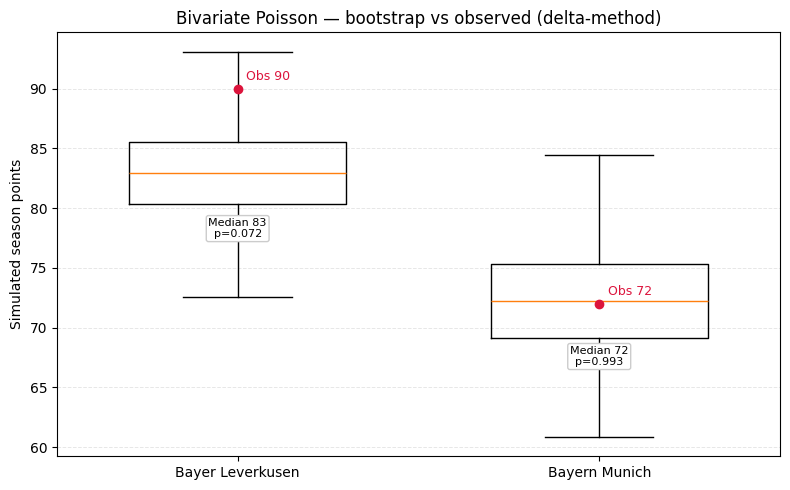

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from math import erf

def _phi(z):  # standard normal CDF
    return 0.5 * (1.0 + erf(z / np.sqrt(2.0)))

# Pull BP medians/CIs already computed
def _get_bp_params(team):
    row = season_ci_bp.loc[season_ci_bp["team"] == team]
    if row.empty:
        raise ValueError(f"Team not found in season_ci_bp: {team}")
    mu  = float(row["xPts_bp_med"].iloc[0])
    lo  = float(row["xPts_bp_lo"].iloc[0])
    hi  = float(row["xPts_bp_hi"].iloc[0])
    se  = max(1e-6, (hi - lo) / (2.0 * 1.96))
    mrow = season_bp.loc[season_bp["team"] == team]
    M = int(mrow["matches"].iloc[0]) if not mrow.empty else int(df.shape[0] // 2 // len(teams) * (len(teams)-1))
    lo_cap, hi_cap = 0.0, 3.0 * M
    return mu, se, lo_cap, hi_cap

mu_A, se_A, loA, hiA = _get_bp_params(obs_A["team"])
mu_B, se_B, loB, hiB = _get_bp_params(obs_B["team"])

N_SIM_PLOT = 1000
rng = np.random.default_rng(909)
draws_A = np.clip(rng.normal(mu_A, se_A, size=N_SIM_PLOT), loA, hiA)
draws_B = np.clip(rng.normal(mu_B, se_B, size=N_SIM_PLOT), loB, hiB)

def two_sided_p_norm(mu, se, obs):
    if se <= 0: return 1.0 if abs(obs - mu) < 1e-9 else 0.0
    z = (obs - mu) / se
    return float(2.0 * min(_phi(z), 1.0 - _phi(z)))

A_med, B_med = float(np.median(draws_A)), float(np.median(draws_B))
A_p = two_sided_p_norm(mu_A, se_A, obs_A["pts_obs"])
B_p = two_sided_p_norm(mu_B, se_B, obs_B["pts_obs"])

fig, ax = plt.subplots(figsize=(8,5))
ax.boxplot([draws_A, draws_B], labels=[obs_A["team"], obs_B["team"]], showfliers=False, widths=0.6)
ax.set_ylabel("Simulated season points")
ax.set_title("Bivariate Poisson — bootstrap vs observed (delta-method)")
ax.grid(True, axis="y", alpha=0.3, linestyle="--", linewidth=0.7)

for i, obs in enumerate([obs_A["pts_obs"], obs_B["pts_obs"]], start=1):
    ax.plot([i], [obs], "o", color="crimson", markersize=6, zorder=3)
    ax.annotate(f"Obs {int(obs)}", xy=(i, obs), xytext=(6, 6),
                textcoords="offset points", fontsize=9, color="crimson")

for i, (med, pval) in enumerate([(A_med, A_p), (B_med, B_p)], start=1):
    ax.annotate(f"Median {med:.0f}\np={pval:.3f}",
                xy=(i, med), xytext=(0, -32),
                textcoords="offset points", ha="center", va="top",
                fontsize=8, bbox=dict(boxstyle="round,pad=0.2", fc="white", ec="0.8"))

plt.tight_layout(); plt.show()


In [ ]:
# === CELL A — Accuracy for Models 1–3 (GBM/Logit family) ===
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd

# y_true: 0 = loss, 1 = draw, 2 = win (team perspective)
y_true = y_class.to_numpy()

def to_ldw_matrix(p_wdl):
    """
    Convert [p_win, p_draw, p_loss] -> [p_loss, p_draw, p_win]
    so columns align with classes 0, 1, 2.
    """
    return np.column_stack([p_wdl[:,2], p_wdl[:,1], p_wdl[:,0]])

def safe_probs(p):
    p = np.clip(p, 1e-15, 1-1e-15)
    return p / p.sum(axis=1, keepdims=True)

# --- Model 1 ---
probs1_wdl = probs_final  # shape (N,3): [p_win, p_draw, p_loss]
probs1_ldw = safe_probs(to_ldw_matrix(probs1_wdl))
y_pred1 = probs1_ldw.argmax(axis=1)
acc1 = accuracy_score(y_true, y_pred1)

# --- Model 2 ---
probs2_wdl = final_probs2[["p_win","p_draw","p_loss"]].to_numpy(float)
probs2_ldw = safe_probs(to_ldw_matrix(probs2_wdl))
y_pred2 = probs2_ldw.argmax(axis=1)
acc2 = accuracy_score(y_true, y_pred2)

# --- Model 3 ---
probs3_wdl = final_pdf3[["p_win","p_draw","p_loss"]].to_numpy(float)
probs3_ldw = safe_probs(to_ldw_matrix(probs3_wdl))
y_pred3 = probs3_ldw.argmax(axis=1)
acc3 = accuracy_score(y_true, y_pred3)

metrics_1_3 = pd.DataFrame(
    {"Accuracy": [acc1, acc2, acc3]},
    index=[
        "Model 1: GBM–Logit Baseline",
        "Model 2: Penalized Logit",
        "Model 3: Double-Poisson (Skellam) Simulation",
    ],
)

print("=== Accuracy (W/D/L) — Models 1–3 ===")
print(metrics_1_3.round(4).to_string())
